In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

from shapely import wkt
import contextily as ctx
import seaborn as sns

from utils import make_precinct_counts,make_demo_map,job_cols,race_cols,cols_to_keep,scale_and_cluster,make_edname,map_round_votes,zip_list,brooklyn_zips

In [2]:
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA

In [3]:
demo_cluster = pd.read_csv('../../chapter_two/data/occupation_demo_clusters_on_ed.csv')
d36 = pd.read_csv('../../cc_election_cleaning/all_rounds_results/district_36.csv')
ed_level = pd.read_csv('../../cc_election_cleaning/occupation_demo_data_feb21.csv')
fwe = pd.read_csv('../data/finance_with_ethnicity.csv')

ed_shapefile = '../../chapter_two/data/nyed_21a/nyed.shp'
ed_gdf = gpd.read_file(ed_shapefile)


fifty_seven = pd.read_csv('../data/fifty_seventh_assem.csv')
fifty_seven = fifty_seven[['aded','percphara','percmos']]
full_results = pd.read_csv('../../cc_election_cleaning/election_results_with_vote_sponsor_cluster_FEB13.csv')
co = full_results[full_results['candidate'] == 'Chi A. Osse']
winner = full_results[full_results['winner'] == True]

full_results_thirty_six = full_results[full_results['district'] == 36]
occ_df = pd.read_csv('../../cc_election_cleaning/occupation_election_feb21.csv')


In [4]:

nyc_zip = gpd.read_file('../data/Modified Zip Code Tabulation Areas (MODZCTA).geojson')

In [5]:
occ_df = pd.read_csv('../../cc_election_cleaning/occupation_election_feb21.csv')

In [6]:
ae = pd.read_csv('../../cc_election_cleaning/additional_variables.csv')

## The District 

District 36 is primarily Budford-Stuvyset with a portion of Crown Heights. The district is historically a center of Black political power and is currently one of the centers of rapid demographic change. 53% of the district is non-Hispanic Black, putting in the top quintile of council districts. While its is relatively low in white population in general, in the next to lowest quintile, is is in the second quintile of white transplant population, with 10 percent of the district being NH whites born out of state. 

In [17]:
full_results = pd.read_csv('../../cc_election_cleaning/election_results_with_vote_sponsor_cluster_FEB13.csv')
co = full_results[full_results['candidate'] == 'Chi A. Ossé']

In [12]:
co = gpd.GeoDataFrame(co,geometry=co['geometry'].apply(wkt.loads))
#co = co.set_crs(epsg=2263, allow_override=True)
#co_3857 = co.to_crs(epsg=3857)

In [21]:
full_results['candidate'].unique()

array(['Carlina Rivera', 'Erin Hussein', 'Write-in', '217703.0',
       '221474.0', 'overvote', 'Johanna Garcia', 'Carmen N. De La Rosa',
       'Angela Fernandez', 'James E. Behr', 'Francesca M. Castellanos',
       'Thomas A. Leon', 'Josue Perez', '219203.0', '217810.0',
       '218489.0', '221467.0', '220804.0', 'Tirso S. Pina', '221454.0',
       '221285.0', 'Christopher Marte', 'Maud Maron', 'Jenny L. Low',
       'Gigi Li', 'Tiffany Johnson-Winbush', 'Sean C. Hayes', 'Susan Lee',
       'Denny R. Salas', 'Susan Damplo', '219626.0', '218026.0',
       '217983.0', '219472.0', '217769.0', '221445.0', '218316.0',
       '221284.0', '221305.0', 'Erik D. Bottcher', 'Arthur Z. Schwartz',
       'Leslie Boghosian Murphy', 'Marni Halasa', 'Aleta A. LaFargue',
       'Phelan D. Fitzpatrick', '217684.0', '221150.0', '217795.0',
       '217561.0', '220463.0', '219991.0', 'Julie Menin',
       'Tricia M. Shimamura', 'Billy Freeland', 'Rebecca N. Lamorte',
       'Christopher  A. Sosa', 'Kim M

C:\Users\samtg\AppData\Local\Temp\ipykernel_30000\2166835879.py:2: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  co.plot(
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\contextily\tile.py:645: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


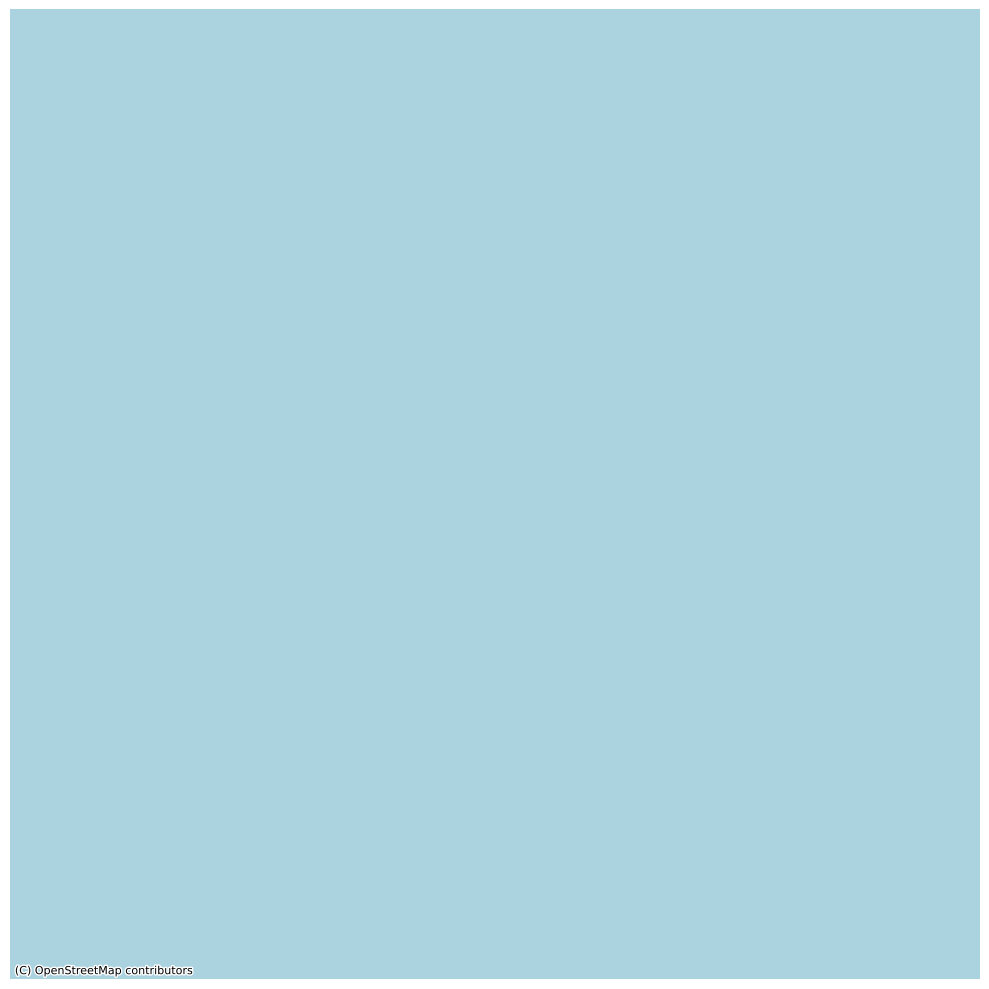

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
co.plot(
    column="white_transplant_ratio",
    legend=True,
    ax=ax,
    alpha=0.6,
    edgecolor="k",
    cmap="viridis",
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [4]:
full_results_thirty_six.groupby('candidate')['vote'].sum().sort_values(ascending=False)

candidate
Chi A. Osse         8445.0
Henry L. Butler     5361.0
Tahirah A. Moore    5264.0
Robert Waterman     3222.0
Reginald Swiney      615.0
Write-in              84.0
overvote              67.0
219539.0              61.0
219533.0              33.0
218576.0              16.0
218675.0              10.0
221439.0               6.0
Name: vote, dtype: float64

In [7]:
eds_36 = full_results_thirty_six['ed_name'].unique().tolist()

In [22]:
top_three = full_results_thirty_six[full_results_thirty_six['candidate'].isin(['Chi A. Osse','Henry L. Butler','Tahirah A. Moore'])]
winners = top_three.loc[top_three.groupby('ed_name')['vote_share'].idxmax()].copy()
winners['norm'] = winners.groupby('candidate')['vote_share'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)


In [23]:
winners['candidate'].value_counts()

candidate
Chi A. Osse         79
Henry L. Butler     20
Tahirah A. Moore    17
Name: count, dtype: int64

In [97]:
d36.groupby('district_36_choice_1')['district_36_choice_2'].value_counts(dropna=False).reset_index(name='count').sort_values('count', ascending=False).head(20)

district_36_choice_1 district_36_choice_2  count
0           Chi A. Osse     Tahirah A. Moore   3645
1           Chi A. Osse                  NaN   2534
8       Henry L. Butler                  NaN   1754
31     Tahirah A. Moore                  NaN   1621
32     Tahirah A. Moore          Chi A. Osse   1577
9       Henry L. Butler     Tahirah A. Moore   1299
23      Robert Waterman                  NaN   1159
2           Chi A. Osse      Robert Waterman   1152
10      Henry L. Butler      Robert Waterman   1054
33     Tahirah A. Moore      Henry L. Butler    997
3           Chi A. Osse      Henry L. Butler    903
24      Robert Waterman      Henry L. Butler    846
34     Tahirah A. Moore      Robert Waterman    698
11      Henry L. Butler          Chi A. Osse    696
25      Robert Waterman     Tahirah A. Moore    641
12      Henry L. Butler      Reginald Swiney    473
26      Robert Waterman          Chi A. Osse    359
35     Tahirah A. Moore      Reginald Swiney    334
4           Chi A. Osse      Reginald Swiney    186
16      Reginald Swiney                  NaN    184

In [24]:
def assign_color(row):
    if row['candidate'] == 'Chi A. Osse':
        return mpl.cm.Blues(row['norm'])
    elif row['candidate'] == 'Henry L. Butler':
        return mpl.cm.Reds(row['norm'])
    else:
        return mpl.cm.Greens(row['norm'])

In [25]:
winners['color'] = winners.apply(assign_color, axis=1)

In [26]:
winners = gpd.GeoDataFrame(winners,geometry=winners['geometry'].apply(wkt.loads))

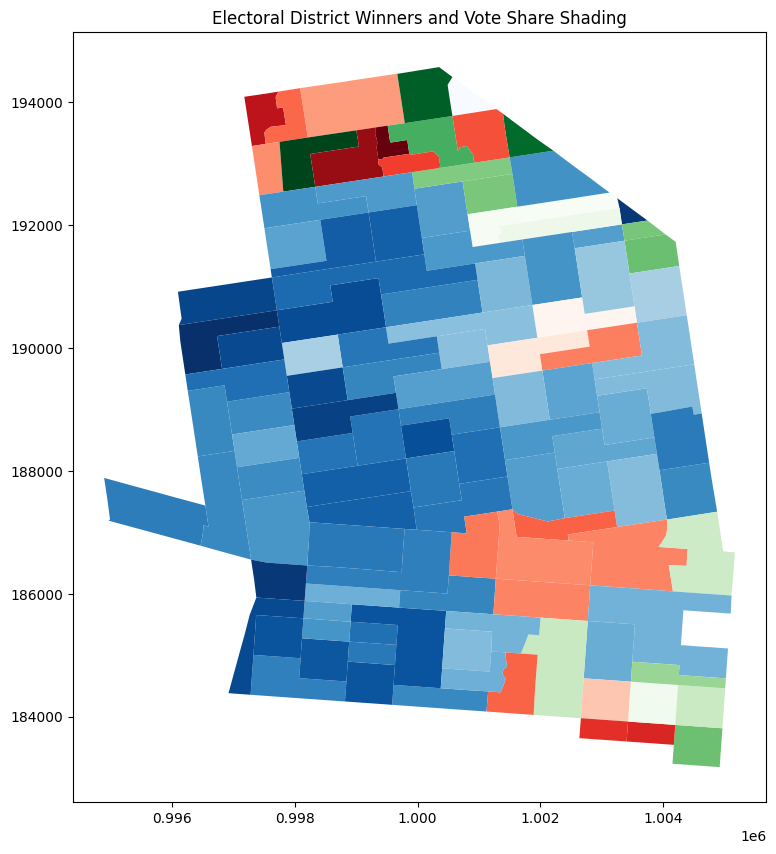

In [27]:

fig, ax = plt.subplots(1, figsize=(10, 10))
winners.plot(color=winners['color'], ax=ax)
ax.set_title("Electoral District Winners and Vote Share Shading")
plt.show()

In [14]:
hb = full_results_thirty_six[full_results_thirty_six['candidate'] == 'Henry L. Butler']

In [ ]:
hb.plot(column='white_transplant_ratio',legend=True)
plt.show()

In [ ]:
co = gpd.GeoDataFrame(co,geometry=co['geometry'].apply(wkt.loads))
co = co.set_crs(epsg=2263, allow_override=True)
co_3857 = co.to_crs(epsg=3857)

In [124]:
co['geometry']

19221    POLYGON ((1000377.681 184462.290, 1000681.482 ...
19228    POLYGON ((998096.534 184950.691, 998073.528 18...
19234    POLYGON ((998887.723 185220.723, 998864.967 18...
19240    POLYGON ((999632.853 184839.539, 999609.759 18...
19245    POLYGON ((999655.464 185168.020, 999632.853 18...
                               ...                        
19892    POLYGON ((998208.479 186460.488, 998202.636 18...
19899    POLYGON ((998162.045 185884.098, 998142.505 18...
19904    POLYGON ((997871.829 189548.290, 997912.844 18...
19913    POLYGON ((997061.191 188059.743, 997101.929 18...
19923    POLYGON ((998115.326 187946.925, 998156.346 18...
Name: geometry, Length: 115, dtype: geometry

In [131]:
print(co.crs)

None


In [132]:
co = co.set_crs(epsg=2263, allow_override=True)

In [133]:
co_3857 = co.to_crs(epsg=3857)

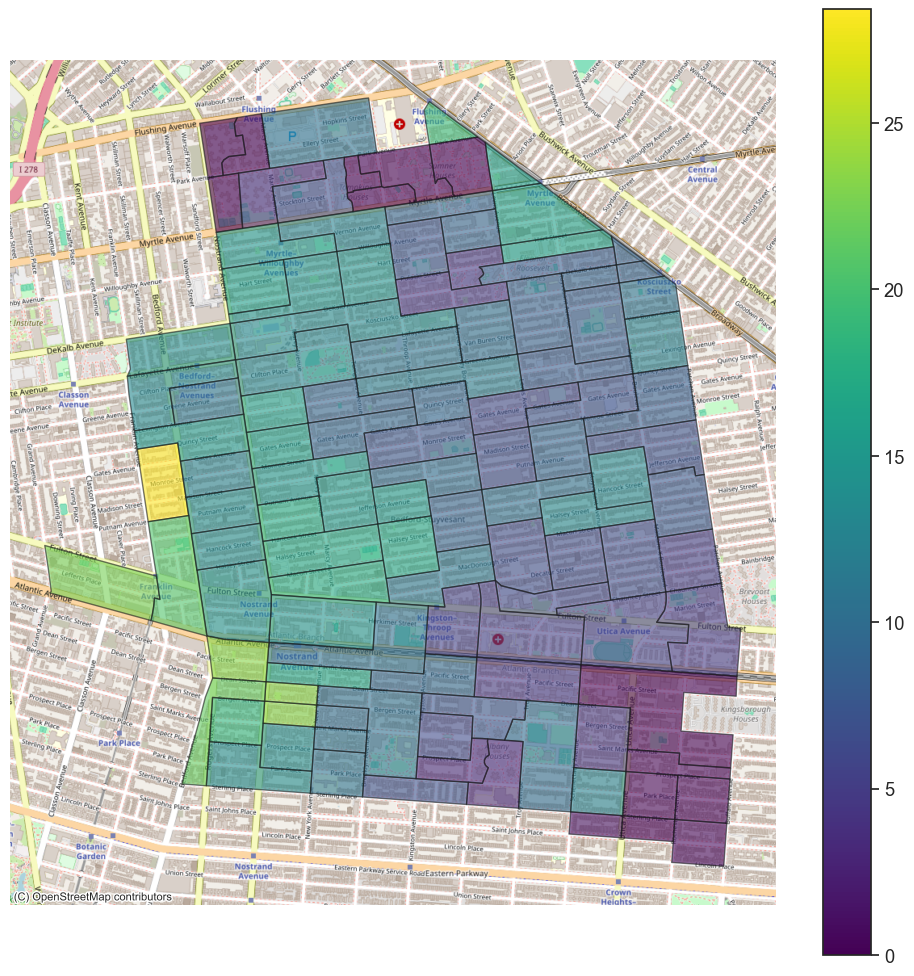

In [140]:
fig, ax = plt.subplots(figsize=(10, 10))
co_3857.plot(
    column="white_transplant_ratio",
    legend=True,
    ax=ax,
    alpha=0.6,
    edgecolor="k",
    cmap="viridis",
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [ ]:
hb = gpd.GeoDataFrame(hb,geometry=hb['geometry'].apply(wkt.loads))

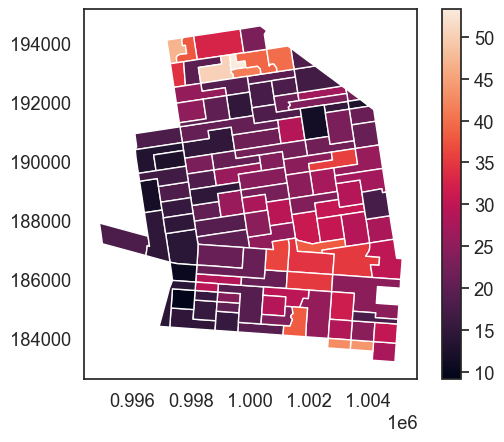

In [91]:
hb.plot(column='vote_share',legend=True)
plt.show()

In [17]:
winners = winners[['candidate','ed_name','white_transplant_ratio','adams213p', 'bus_ratio', 'dpp20bs', 'hh21op', 'vote_share']].merge(ed_level, left_on = 'ed_name', right_on = 'ElectDist')

In [18]:
winners = winners.merge(occ_df, left_on = 'ed_name', right_on = 'ElectDist',how='left')

In [10]:
p_cols = [col for col in occ_df.columns if col[-1] == 'p']
wp_cols = [col for col in occ_df.columns if col.startswith("w2") and col.endswith("p")]
wp_cols.remove('w2cop')

In [20]:
tdc = ['w2hsp','w2govp','w2mgtp','w2admp','w2npp']

In [23]:
winners[tdc].describe().round(2)

w2hsp  w2govp  w2mgtp  w2admp   w2npp
count  116.00  116.00  116.00  116.00  116.00
mean    10.42   16.09   11.08    9.95   12.15
std     10.26    6.63    4.72    4.76    5.06
min      0.00    3.93    0.00    0.00    2.47
25%      4.31   11.00    8.24    7.27    8.93
50%      7.75   15.04   10.69    9.55   11.27
75%     10.82   20.57   13.69   12.58   13.78
max     50.26   33.98   24.09   24.24   39.24

In [21]:
winners.groupby('candidate')[tdc].agg("mean")

w2hsp     w2govp     w2mgtp     w2admp      w2npp
candidate                                                              
Chi A. Osse        7.026119  15.270848  12.841944  11.498912  12.171968
Henry L. Butler   18.442077  20.964653   6.866116   5.903333  12.703727
Tahirah A. Moore  16.747506  14.189387   7.839034   7.517251  11.370634

In [24]:
mean_values = winners.groupby('candidate')[wp_cols].agg("mean")
diffs = mean_values.max() - mean_values.min()  
top_diff_cols = diffs.nlargest(10)
print(top_diff_cols)

w2hsp      11.415958
w2govp      6.775266
w2mgtp      5.975827
w2admp      5.595579
w2psp       3.843500
w2foodp     3.799795
w2banp      3.445499
w2ffp       2.931861
w2bgp       2.914686
w2oadp      2.757806
dtype: float64


In [12]:
winners.groupby('candidate').agg({'vote_share':'mean',
                                  'white_transplant_ratio':'mean',
                                  'mhhi21':'mean',
                                  'hh21op':'mean',
                                  'adams213p':'mean',
                                  'dpp20bs':'mean',
                                    'cvap21bapp':'mean',
                                    'bus_ratio':'mean',
                                    'Retail Trade':'mean',
                                    'Information':'mean',
                                    'Professional, Scientific, and Technical Services':'mean',
                                    'Educational Services':'mean',
                                    'Health Care and Social Assistance':'mean',
                                    'Construction':'mean'
}).round(2)

vote_share  white_transplant_ratio    mhhi21  hh21op  \
candidate                                                                
Chi A. Osse            40.50                   12.30  80372.90   23.33   
Henry L. Butler        37.58                    4.19  66642.07   15.17   
Tahirah A. Moore       36.10                    7.19  50181.59   15.53   

                  adams213p  dpp20bs  cvap21bapp  bus_ratio  Retail Trade  \
candidate                                                                   
Chi A. Osse           48.52   203.33       40.46       6.59         11.00   
Henry L. Butler       68.86    95.47       31.85      13.34         11.94   
Tahirah A. Moore      61.89   110.79       33.27      12.67         11.76   

                  Information  \
candidate                       
Chi A. Osse              4.83   
Henry L. Butler          3.86   
Tahirah A. Moore         4.07   

                  Professional, Scientific, and Technical Services  \
candidate                                                            
Chi A. Osse                                                   8.30   
Henry L. Butler                                               6.91   
Tahirah A. Moore                                              7.35   

                  Educational Services  Health Care and Social Assistance  \
candidate                                                                   
Chi A. Osse                       5.66                              19.91   
Henry L. Butler                   5.55                              21.68   
Tahirah A. Moore                  5.00                              20.55   

                  Construction  
candidate                       
Chi A. Osse               3.12  
Henry L. Butler           3.37  
Tahirah A. Moore          3.53

In [25]:
d36.groupby('district_36_choice_1')['district_36_choice_2'].value_counts(dropna=False).reset_index(name='count').sort_values('count', ascending=False).head(10)

district_36_choice_1 district_36_choice_2  count
0           Chi A. Osse     Tahirah A. Moore   3645
1           Chi A. Osse                  NaN   2534
8       Henry L. Butler                  NaN   1754
31     Tahirah A. Moore                  NaN   1621
32     Tahirah A. Moore          Chi A. Osse   1577
9       Henry L. Butler     Tahirah A. Moore   1299
23      Robert Waterman                  NaN   1159
2           Chi A. Osse      Robert Waterman   1152
10      Henry L. Butler      Robert Waterman   1054
33     Tahirah A. Moore      Henry L. Butler    997

salazar primary

In [26]:
colnames = ['a', 'b', 'c', 'd', 'e', 'f',
       'g', 'h', 'i', 'j',
       'k', 
        'AD', 'ED', 'County', 'EDAD Status', 'Event', 'Party/Independent Body',
       'Office/Position Title', 'District Key', 'VoteFor', 'Unit Name',
       'Tally']

good_cols = ['AD', 'ED', 'County', 'EDAD Status', 'Event', 'Party/Independent Body',
       'Office/Position Title', 'District Key', 'VoteFor', 'Unit Name',
       'Tally']

In [27]:
sp = pd.read_csv('../data/salazar_raw_primary.csv',header=None, names=colnames)
sp = sp[good_cols]

In [28]:
sp['precinct'] = 'AD: ' + sp['AD'].astype(str) + ' ' + 'ED: ' + sp['ED'].astype(str).str.zfill(3)
sp['ed_name'] = sp['AD'].astype(str) + sp['ED'].astype(str).str.zfill(3)

In [29]:
candidates = ['Julia Salazar','Martin Malave Dilan']

In [30]:
sp_cand = sp[sp['Unit Name'].isin(candidates)]
sp_cand = sp_cand[['precinct','ed_name','Unit Name','Tally']]

In [31]:
sp_cand.columns = ['precinct','ed_name','candidate','votes']

In [32]:
sp_cand['ed_total'] = sp_cand.groupby('ed_name')['votes'].transform('sum')
sp_cand['vote_share'] = round(sp_cand['votes'] / sp_cand['ed_total'] * 100,2)

In [33]:
sp_cand['vote_share'] = pd.to_numeric(sp_cand['vote_share'], errors='coerce')
sp_cand = sp_cand.dropna(subset=['vote_share'])

In [34]:
max_vote_share_candidates = sp_cand.loc[sp_cand.groupby('ed_name')['vote_share'].idxmax()]

In [35]:
max_vote_share_candidates['candidate'].value_counts()

candidate
Julia Salazar          147
Martin Malave Dilan     89
Name: count, dtype: int64

In [36]:
max_vote_share_candidates.to_csv('../data/max_vote_share_candidates_js.csv',index=False)

In [37]:
mvsc_js = max_vote_share_candidates.copy()

In [38]:
mvsc_jb = pd.read_csv('../data/max_vote_share_candidates.csv')
mvsc_js = pd.read_csv('../data/max_vote_share_candidates_js.csv')

In [39]:
mvs = pd.concat([mvsc_js,mvsc_jb])

In [40]:
mvs_36 = mvs[mvs['ed_name'].isin(eds_36)]

In [41]:
mvs_36['candidate'].value_counts()

candidate
Jabari Brisport        55
Tremaine S. Wright     33
Julia Salazar          13
Martin Malave Dilan    10
Name: count, dtype: int64

In [ ]:
mvs_36_map = mvs_36.merge(ed_gdf, left_on = 'ed_name',right_on='ElectDist')
mvs_36_map = gpd.GeoDataFrame(mvs_36_map,geometry=mvs_36_map['geometry'])
gdf_3857 = mvs_36_map.to_crs(epsg=3857)

In [51]:
gdf_3857 = mvs_36_map.to_crs(epsg=3857)

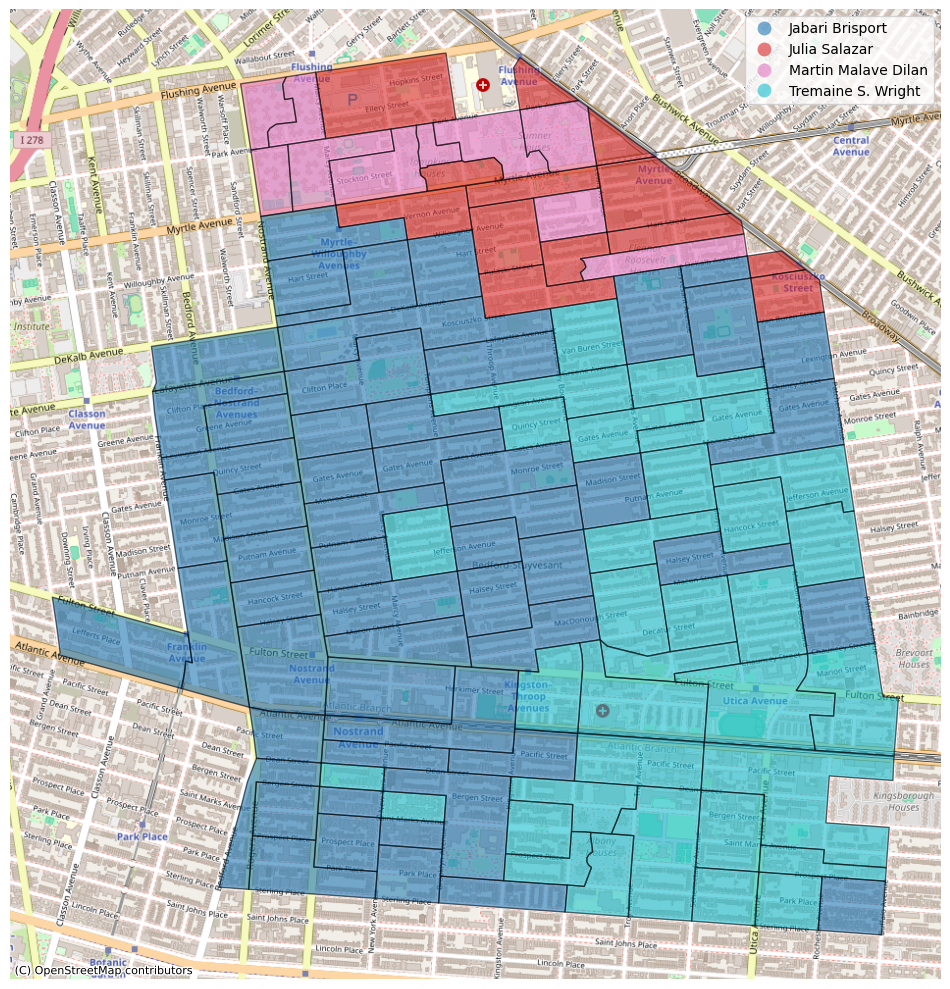

In [ ]:
mvs_36_map = mvs_36.merge(ed_gdf, left_on = 'ed_name',right_on='ElectDist')
mvs_36_map = gpd.GeoDataFrame(mvs_36_map,geometry=mvs_36_map['geometry'])
gdf_3857 = mvs_36_map.to_crs(epsg=3857)


ax = gdf_3857.plot(
    column='candidate',
    legend=True,
    figsize=(10, 10),
    alpha=0.6,
    edgecolor='k'
)

ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik, 
    crs=gdf_3857.crs
)

ax.set_axis_off()
plt.tight_layout()
plt.show()

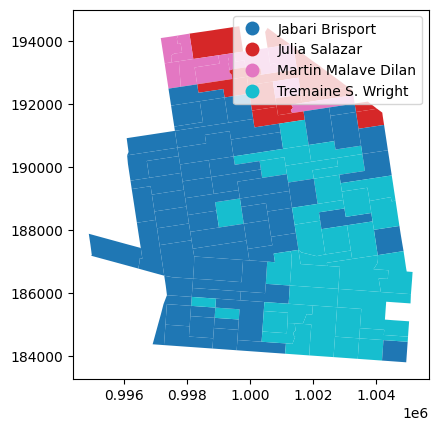

In [43]:
mvs_36_map.plot(column='candidate',legend=True)
plt.show()

In [44]:
mvs_36.columns = ['precinct','ed_name','sen_candidate','votes','ed_total','vote_share']

In [45]:
winners_br = winners.merge(mvs_36, on = 'ed_name', how = 'left')

In [46]:
winners_br['sen_candidate'].value_counts()

sen_candidate
Jabari Brisport        55
Tremaine S. Wright     33
Julia Salazar          13
Martin Malave Dilan    10
Name: count, dtype: int64

In [47]:
winners_br.dropna(subset=['sen_candidate'],inplace=True)

In [48]:
conditions = [
    (winners_br["candidate"] == "Chi A. Osse") & 
    (winners_br["sen_candidate"].isin(['Julia Salazar',"Jabari Brisport"])),
    
    (winners_br["candidate"] == "Chi A. Osse") & 
    (winners_br["sen_candidate"].isin(['Martin Malave Dilan',"Tremaine S. Wright"])),
    
    (winners_br["candidate"].isin(['Henry L. Butler','Tahirah A. Moore'])) & 
    (winners_br["sen_candidate"].isin(['Julia Salazar',"Jabari Brisport"])),

    (winners_br["candidate"].isin(['Henry L. Butler','Tahirah A. Moore'])) & 
    (winners_br["sen_candidate"].isin(['Martin Malave Dilan',"Tremaine S. Wright"])),
]

values = ['dsa_stonghold','prog_not_dsa','dsa_not_prog','non_prog'] 

winners_br["cc_sen_cats"] = np.select(conditions, values, default=0)

In [49]:
winners_br['cc_sen_cats'].value_counts()

cc_sen_cats
dsa_stonghold    59
non_prog         24
prog_not_dsa     19
dsa_not_prog      9
Name: count, dtype: int64

In [99]:
top_diff_cols = ['w2hsp','w2govp','w2mgtp','w2admp','w2npp','w2psp']

In [100]:
winners_br.groupby('cc_sen_cats')[top_diff_cols].agg("mean")

w2hsp     w2govp     w2mgtp     w2admp      w2npp  \
cc_sen_cats                                                            
dsa_not_prog   14.784762  12.416222   7.103771   8.958833  10.947898   
dsa_stonghold   7.163919  14.426166  13.002832  12.127849  12.275481   
non_prog       19.350597  19.737162   7.158380   5.629815  12.383139   
prog_not_dsa    6.398340  18.118427  12.754268   9.655495  11.831248   

                   w2psp  
cc_sen_cats               
dsa_not_prog   66.144075  
dsa_stonghold  62.527433  
non_prog       60.920899  
prog_not_dsa   59.772062

In [98]:
mean_values = winners_br.groupby('candidate')[wp_cols].agg("mean")
diffs = mean_values.max() - mean_values.min()  
top_diff_cols = diffs.nlargest(10)
print(top_diff_cols)

w2hsp      13.085257
w2govp      6.431897
w2mgtp      5.948496
w2admp      5.733716
w2psp       4.567109
w2banp      3.513990
w2foodp     3.428646
w2bgp       3.320802
w2oadp      2.672164
w2ffp       2.657992
dtype: float64


In [112]:
key_demo_cols = ['white_transplant_ratio','nhw21p','nhb21p', 'bus_ratio', 'mhhi21', 'cvap21bapp']
key_demo_cols.extend(top_diff_cols)

In [136]:
df_cluster = winners_br[key_demo_cols]

In [137]:
scaler = StandardScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster)

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

Text(0.5, 1.0, 'Elbow Method')

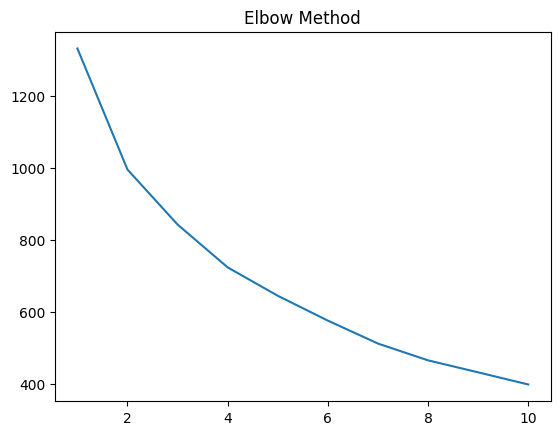

In [115]:
# elbow method to determine number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(df_cluster_scaled)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia)
plt.title('Elbow Method')

In [138]:
kmeans = KMeans(n_clusters=5, random_state=14)
kmeans.fit(df_cluster_scaled)
winners_br['occ_cluster'] = kmeans.labels_

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [130]:
winners_br.groupby('occ_cluster')[key_demo_cols].agg("mean")

white_transplant_ratio     nhw21p     nhb21p  bus_ratio  \
occ_cluster                                                            
0                          0.000001   5.743136  33.465335  23.362909   
1                         16.220384  30.069700  33.533743   3.875735   
2                          8.491230  22.597548  21.081107   9.088345   
3                          5.601641  15.646747  41.777565  13.620584   
4                         14.576627  21.214961  19.659743   3.947672   

                    mhhi21  cvap21bapp      w2hsp     w2govp     w2mgtp  \
occ_cluster                                                               
0             29415.409727   18.640635  42.702607  18.783548   2.254108   
1             55905.365998   49.830120   4.503478  13.462521  16.823785   
2             90856.110916   37.690287  12.272124  15.820518  10.033501   
3             57312.535986   35.091040   7.130335  23.532109   9.323103   
4            100906.010329   36.582089   6.523172  11.444904  12.041690   

                w2admp      w2npp      w2psp  
occ_cluster                                   
0             0.847797  19.358635  59.709608  
1            11.655522  15.689413  59.449652  
2             7.939228   9.492755  65.405335  
3             8.188468  11.685941  55.740621  
4            15.473326  10.932754  65.625051

In [121]:
winners_br['occ_cluster'] = winners_br['occ_cluster'].astype('category')

In [123]:
winners_br.groupby('cc_sen_cats').agg({'nhw21p':'mean',
                                       'nhb21p':'mean',
                                  'white_transplant_ratio':'mean',
                                  'mhhi21':'median',
                                  'hh21op':'mean',
                                  'adams213p':'mean',
                                  'dpp20bs':'mean',
                                    'cvap21bapp':'mean',
                                    'bus_ratio':'mean',
                                    'Retail Trade':'mean',
                                    'Information':'mean',
                                    'Professional, Scientific, and Technical Services':'mean',
                                    'Educational Services':'mean',
                                    'Health Care and Social Assistance':'mean',
                                    'Construction':'mean',
                                    'Management of Companies and Enterprises':'mean',
                                    'Finance and Insurance':'mean'
}).round(2)

nhw21p  nhb21p  white_transplant_ratio    mhhi21  hh21op  \
cc_sen_cats                                                               
dsa_not_prog    19.78   24.39                    8.47  42704.31   16.42   
dsa_stonghold   22.52   27.47                   13.46  69721.73   21.77   
non_prog        15.33   28.09                    4.52  62767.75   17.03   
prog_not_dsa    25.85   31.83                    8.89  84042.48   28.42   

               adams213p  dpp20bs  cvap21bapp  bus_ratio  Retail Trade  \
cc_sen_cats                                                              
dsa_not_prog       60.00   127.19       34.25      11.66         11.69   
dsa_stonghold      45.74   213.27       39.90       5.66         11.11   
non_prog           67.78   105.26       32.01      14.29         11.91   
prog_not_dsa       56.86   173.73       42.13       9.38         10.66   

               Information  Professional, Scientific, and Technical Services  \
cc_sen_cats                                                                    
dsa_not_prog          4.25                                              7.62   
dsa_stonghold         4.85                                              8.34   
non_prog              3.86                                              6.94   
prog_not_dsa          4.79                                              8.18   

               Educational Services  Health Care and Social Assistance  \
cc_sen_cats                                                              
dsa_not_prog                   5.25                              20.05   
dsa_stonghold                  5.41                              19.72   
non_prog                       5.43                              21.40   
prog_not_dsa                   6.44                              20.55   

               Construction  Management of Companies and Enterprises  \
cc_sen_cats                                                            
dsa_not_prog           3.28                                     1.71   
dsa_stonghold          3.09                                     1.80   
non_prog               3.44                                     1.63   
prog_not_dsa           3.19                                     1.79   

               Finance and Insurance  
cc_sen_cats                           
dsa_not_prog                    5.44  
dsa_stonghold                   5.73  
non_prog                        4.98  
prog_not_dsa                    5.98

In [119]:
cor_cols = ['vote_share_x','vote_share_y', 'mhhi21','cvap21bapp', 'dpp20bs','nhb21p', 'nhw21p','white_transplant_ratio',]

In [120]:
cor_matrix = winners_br[cor_cols].corr()
cor_matrix

vote_share_x  vote_share_y    mhhi21  cvap21bapp  \
vote_share_x                1.000000      0.479872 -0.047944    0.217616   
vote_share_y                0.479872      1.000000 -0.134642    0.095673   
mhhi21                     -0.047944     -0.134642  1.000000   -0.162835   
cvap21bapp                  0.217616      0.095673 -0.162835    1.000000   
dpp20bs                     0.536167      0.471443 -0.250226    0.499500   
nhb21p                      0.097924     -0.106776 -0.678223    0.205515   
nhw21p                      0.049708      0.006232 -0.062276    0.688311   
white_transplant_ratio      0.462823      0.426187 -0.091693    0.526628   

                         dpp20bs    nhb21p    nhw21p  white_transplant_ratio  
vote_share_x            0.536167  0.097924  0.049708                0.462823  
vote_share_y            0.471443 -0.106776  0.006232                0.426187  
mhhi21                 -0.250226 -0.678223 -0.062276               -0.091693  
cvap21bapp              0.499500  0.205515  0.688311                0.526628  
dpp20bs                 1.000000  0.012202  0.289943                0.746586  
nhb21p                  0.012202  1.000000  0.015101               -0.098088  
nhw21p                  0.289943  0.015101  1.000000                0.485411  
white_transplant_ratio  0.746586 -0.098088  0.485411                1.000000

In [54]:
winners_br = winners_br.merge(ed_gdf, left_on = 'ed_name',right_on='ElectDist')
winners_br_map = gpd.GeoDataFrame(winners_br,geometry=winners_br['geometry'])

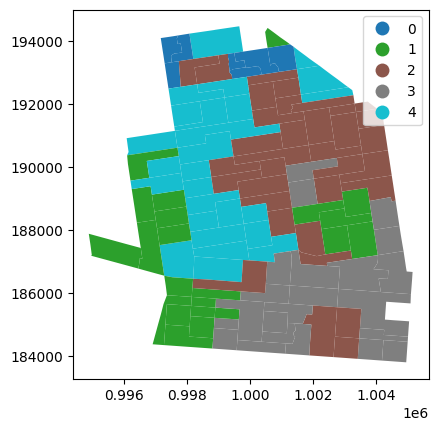

In [140]:
winners_br_map["occ_cluster"] = winners_br_map["occ_cluster"].astype('category')
winners_br_map.plot(column='occ_cluster',legend=True,cmap = 'tab10')
plt.show()

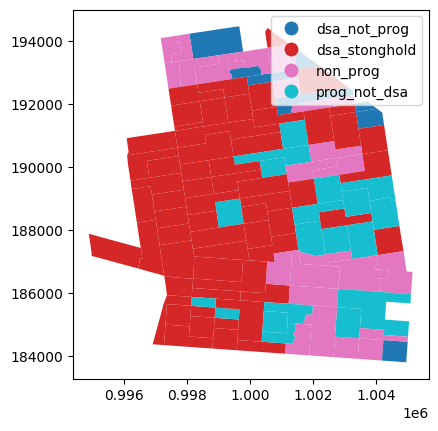

In [55]:
winners_br_map["cc_sen_cats"] = winners_br_map["cc_sen_cats"].astype('category')
winners_br_map.plot(column="cc_sen_cats",legend=True,cmap = 'tab10')
plt.show()

In [11]:
ae

ElectDist    Shape_Leng    Shape_Area  \
0         23001  25826.498431  2.613472e+07   
1         23002  13932.130458  5.637463e+06   
2         23006   8261.763819  3.188046e+06   
3         23008   9028.976073  2.914810e+06   
4         23009   8989.997452  2.779038e+06   
...         ...           ...           ...   
5835      79079   1777.738888  5.897164e+04   
5836      81076   3350.695323  4.984008e+05   
5837      81079   7045.203482  1.857550e+06   
5838      56037   3211.207387  6.443185e+05   
5839      56039   2669.769783  4.291124e+05   

                                               geometry       p21fb  \
0     POLYGON ((1007309.8452148438 141975.6732177734...   33.110375   
1     MULTIPOLYGON (((1006386.2789916992 144120.6552...   29.908494   
2     POLYGON ((1025021.7086181641 147481.0651855468...  116.528261   
3     POLYGON ((1026756.3640136719 147970.5953979492...  133.501426   
4     POLYGON ((1027647.7304077148 148397.8187866211...  154.830080   
...                                                 ...         ...   
5835  POLYGON ((1007283.9122314453 239634.5933837890...   62.127113   
5836  POLYGON ((1009495.5394287109 262265.0709838867...  175.135395   
5837  POLYGON ((1007231.9514160156 263083.5142211914...  166.559972   
5838  POLYGON ((999730.4639892578 188738.05499267578...  324.153699   
5839  POLYGON ((1000556.8436279297 188590.7817993164...  215.884464   

            fb21el  greek21p       arab21p       fb21bdp       fb21drp  \
0     0.000000e+00  0.107342  0.000000e+00  0.000000e+00  0.000000e+00   
1     0.000000e+00  0.449498  0.000000e+00  0.000000e+00  0.000000e+00   
2     0.000000e+00  0.209127  0.000000e+00  0.000000e+00  0.000000e+00   
3     3.846532e-07  0.203822  0.000000e+00  0.000000e+00  0.000000e+00   
4     1.238641e+01  0.635076  0.000000e+00  0.000000e+00  9.111285e-16   
...            ...       ...           ...           ...           ...   
5835  0.000000e+00  0.000000  1.371077e-07  1.584811e+00  1.760552e+01   
5836  1.583701e-01  0.077289  0.000000e+00  0.000000e+00  2.367278e+00   
5837  1.016898e+00  0.076008  1.629611e-01  2.122759e-09  2.884867e+00   
5838  8.629090e+00  0.066181  0.000000e+00  0.000000e+00  5.956323e-01   
5839  5.746924e+00  0.066181  0.000000e+00  0.000000e+00  5.956320e-01   

           hh21bop  
0     2.388042e+01  
1     1.000000e+02  
2     0.000000e+00  
3     0.000000e+00  
4     7.671001e-14  
...            ...  
5835  2.020202e+00  
5836  3.694793e+01  
5837  2.063567e+01  
5838  4.062839e+01  
5839  4.062839e+01  

[5840 rows x 11 columns]

In [11]:
cor_cols = ['ed_name','vote_share','garcia213p','white_transplant_ratio','dpp20bs','nhb21p','nha21p','mhhi21','cvap21bapp','hh21bop','arab21p','bus_ratio','subway_ratio'] + wp_cols
corr_df = co.merge(occ_df, left_on='ed_name', right_on='ElectDist', how='left')
corr_df = corr_df.merge(ae, left_on='ElectDist', right_on='ElectDist', how='left')
corr_df['dpp20bs'] = corr_df['dpp20bs'] / 10
cor_cols = corr_df.drop(columns=['ElectDist','geometry','Precinct','ed_name','candidate','matched_name','member','geometry_x','geometry_y']).columns.tolist()
corr_matrix = corr_df[cor_cols].corr()
corr_matrix = corr_matrix.sort_values('vote_share')
vote_corr = corr_matrix[['vote_share']]

In [112]:
vote_corr.sort_values('vote_share', ascending=False).head(38)

vote_share
vote_share                1.000000
vote                      0.855459
winner                    0.814401
wfp24p                    0.787822
garcia213p                0.763255
ML4                       0.735751
dpp20bs                   0.702987
perc_finance              0.693187
wfp24                     0.685067
cvap21bapp                0.653149
white_transplant_ratio    0.641970
w2adm                     0.636725
wm2mgt                    0.636322
wps2mgr                   0.626877
wf2adesm                  0.624486
w2mgr                     0.620588
total_vote_precinct       0.618246
nhw21p                    0.613038
w2admp                    0.612065
wm2profsci                0.600114
w2cm                      0.596800
w2mgt                     0.582908
wf2profsci                0.582361
wf2cm                     0.557131
wf2info                   0.541289
wm2adesm                  0.532922
w2cmp                     0.529882
wni2mgr                   0.525890
w2mgtp                    0.518179
living_alone_ratio        0.514848
wfh_ratio                 0.506336
rv21irp                   0.506049
wm2info                   0.505063
wse2mgr                   0.501849
w2ban                     0.501455
ML1                       0.500216
wf2bizfin                 0.496875
wm2cm                     0.489241

In [12]:
corr_df['log_mhhi21'] = np.log(corr_df['mhhi21'])

In [19]:
target = corr_df['vote_share']
mod1 = sm.OLS(target,sm.add_constant(corr_df[['log_mhhi21','cvap21bapp']])).fit()
mod2 = sm.OLS(target,sm.add_constant(corr_df[['log_mhhi21','cvap21bapp','white_transplant_ratio']])).fit()
mod3 = sm.OLS(target,sm.add_constant(corr_df[['log_mhhi21','cvap21bapp','white_transplant_ratio','w2cmp','w2admp','w2hsp','w2mgtp']])).fit()
mod4 = sm.OLS(target,sm.add_constant(corr_df[['log_mhhi21','w2cmp','w2admp','w2hsp','w2mgtp']])).fit()
mod5 = sm.OLS(target,sm.add_constant(corr_df[['log_mhhi21','cvap21bapp','white_transplant_ratio','w2cmp','w2admp','w2hsp','w2mgtp','w2bgp','w2lawp']])).fit()

In [20]:
print(mod2.summary())

                            OLS Regression Results                            
Dep. Variable:             vote_share   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     31.74
Date:                Wed, 11 Jun 2025   Prob (F-statistic):           6.81e-15
Time:                        14:47:51   Log-Likelihood:                -429.16
No. Observations:                 115   AIC:                             866.3
Df Residuals:                     111   BIC:                             877.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -10

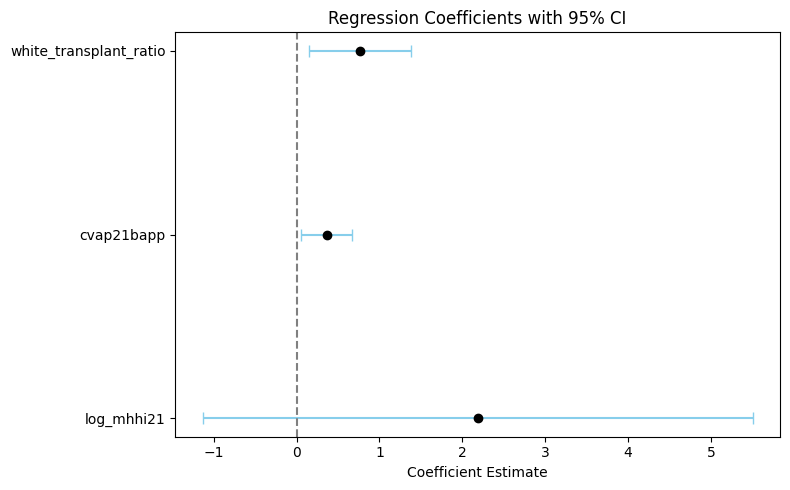

In [22]:
params = mod2.params.drop('const', errors='ignore')
conf = mod2.conf_int().drop('const', errors='ignore')

# Midpoint (coefficient) and error bars
coef = params.values
lower = conf[0].values
upper = conf[1].values
errors = [coef - lower, upper - coef]

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(coef, params.index, xerr=errors, fmt='o', color='black', ecolor='skyblue', capsize=4)
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Coefficient Estimate')
plt.title('Regression Coefficients with 95% CI')
plt.tight_layout()
plt.show()

In [16]:
summary_col([mod1,mod2,mod3,mod4,mod5],stars=True)

<class 'statsmodels.iolib.summary2.Summary'>
"""

=================================================================================================
                       vote_share I vote_share II vote_share III vote_share IIII vote_share IIIII
-------------------------------------------------------------------------------------------------
const                  -11.8495     -10.8759      1.7229         9.1158          21.7653         
                       (15.7754)    (15.4320)     (17.4632)      (16.7374)       (18.0519)       
log_mhhi21             1.7725       2.1853        1.7570         0.8330          0.0820          
                       (1.7025)     (1.6732)      (1.7716)       (1.7452)        (1.7890)        
cvap21bapp             0.6830***    0.3624**      0.1329                         0.0549          
                       (0.0882)     (0.1557)      (0.2374)                       (0.2361)        
white_transplant_ratio              0.7666**      0.6338                         0.5785          
                                    (0.3100)      (0.4204)                       (0.4028)        
w2cmp                                             0.5449         0.9456*         0.6487          
                                                  (0.5294)       (0.5025)        (0.5090)        
w2admp                                            0.4136         0.8716***       0.2052          
                                                  (0.3437)       (0.2796)        (0.3343)        
w2hsp                                             -0.2628        -0.2493*        -0.2007         
                                                  (0.1761)       (0.1345)        (0.1694)        
w2mgtp                                            -0.1354        0.5139*         0.1342          
                                                  (0.3967)       (0.2790)        (0.4009)        
w2bgp                                                                            -0.6126**       
                                                                                 (0.2351)        
w2lawp                                                                           0.9526**        
                                                                                 (0.4265)        
R-squared              0.4321       0.4618        0.5117         0.4850          0.5614          
R-squared Adj.         0.4220       0.4472        0.4797         0.4614          0.5238          
=================================================================================================
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
"""

In [116]:
corr_df['log_mhhi21'] = np.log(corr_df['mhhi21'])

In [143]:
predictors = [
    'log_mhhi21', 'cvap21bapp', 'nhb21p','nhw21p', 'h21p',
    'white_transplant_ratio', 'hh21bop','femHHH_ratio',
    'w2cmp', 'w2admp', 'w2hsp', 'w2mgtp', 'w2bgp', 'w2lawp',
    'hh21op','bus_ratio','living_alone_ratio','w2matp','w2govp',
    'wfh_ratio',
    'drive_ratio','bike_ratio','train_ratio'
]

X = corr_df[predictors]

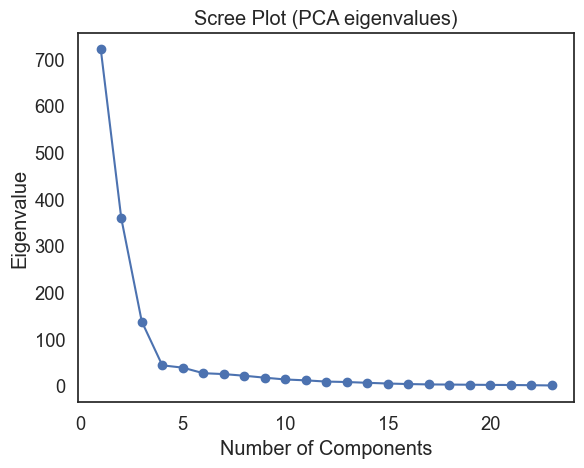

In [144]:
pca = PCA()
pca.fit(X)

# 2) Pull out the eigenvalues
ev = pca.explained_variance_

# 3) Plot the scree
plt.plot(range(1, len(ev) + 1), ev, marker='o')
plt.title('Scree Plot (PCA eigenvalues)')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalue')
plt.show()

In [145]:
n_factors = 4
fa = FactorAnalysis(n_components=n_factors, random_state=0)
factor_scores = fa.fit_transform(X)

In [146]:
fa_df = pd.DataFrame(
    factor_scores,
    columns=[f'Factor{i+1}' for i in range(n_factors)],
    index=corr_df.index
)

In [147]:
loadings = pd.DataFrame(
    fa.components_.T,
    index=predictors,
    columns=fa_df.columns
)
print("Factor Loadings:\n", loadings)

Factor Loadings:
                           Factor1    Factor2   Factor3   Factor4
log_mhhi21              -0.253916   0.234630 -0.126172  0.111621
cvap21bapp              -7.150016   8.848920 -0.215816 -2.714682
nhb21p                  -8.797030 -10.664049  0.005030 -0.386371
nhw21p                  -3.340702  10.325243  0.269959  0.766766
h21p                    13.158214  -1.236066 -0.750880 -0.166935
white_transplant_ratio  -1.739483   5.162557  0.503594 -0.970069
hh21bop                 -6.868119   2.723953 -9.353689 -1.243735
femHHH_ratio             6.329673  -6.749377  0.569123  2.525691
w2cmp                   -0.378506   1.354573  0.005699 -1.141233
w2admp                  -1.693437   3.059592  0.185153 -1.371482
w2hsp                    7.174129  -3.977160  0.294538  3.312360
w2mgtp                  -2.326090   2.879185 -0.091087  0.078338
w2bgp                    1.708939  -1.044556  0.746196 -0.183363
w2lawp                  -0.635820   0.595877  0.218500 -0.665495
hh21op 

In [128]:
loadings.to_csv('../data/36_factor_loadings.csv')

In [129]:
fa_df['vote_share'] = corr_df['vote_share']

In [130]:
fa_df.to_csv('../data/36_factor_scores.csv')

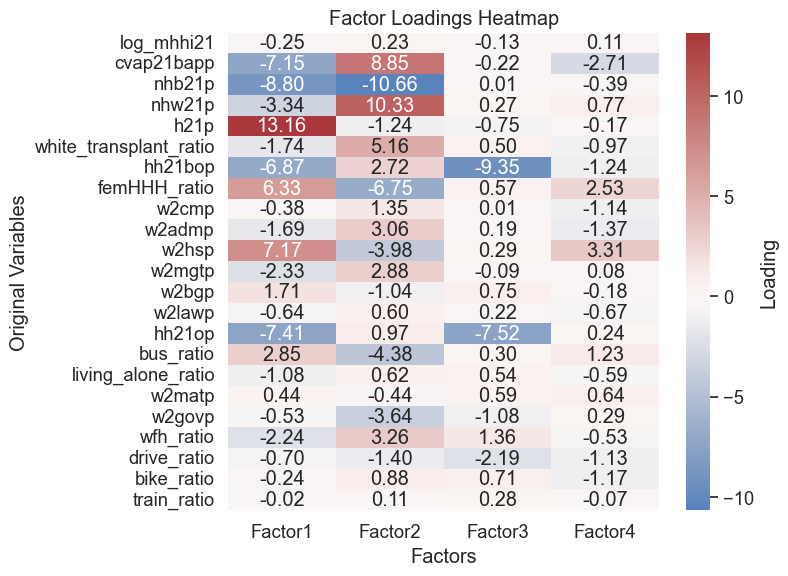

In [127]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    loadings,
    annot=True,         
    fmt=".2f",           
    cmap="vlag",         
    center=0,            
    cbar_kws={"label": "Loading"}
)
plt.title("Factor Loadings Heatmap")
plt.xlabel("Factors")
plt.ylabel("Original Variables")
plt.tight_layout()
plt.show()

In [142]:
Y = corr_df['vote_share']
model_fa = sm.OLS(Y, sm.add_constant(fa_df)).fit()
print(model_fa.summary())

                            OLS Regression Results                            
Dep. Variable:             vote_share   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     30.15
Date:                Wed, 21 May 2025   Prob (F-statistic):           3.96e-19
Time:                        12:56:53   Log-Likelihood:                -414.85
No. Observations:                 115   AIC:                             841.7
Df Residuals:                     109   BIC:                             858.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.0399      6.953      4.321      0.0

In [63]:
fa_df['ed_name'] = corr_df['ed_name']
fa_df['vote_share'] = corr_df['vote_share']

In [67]:
fa_map = fa_df.merge(ed_gdf, right_on='ElectDist', left_on='ed_name', how='left')

In [68]:
fa_map = gpd.GeoDataFrame(fa_map,geometry=fa_map['geometry'])
fa_map_3857 = fa_map.to_crs(epsg=3857)

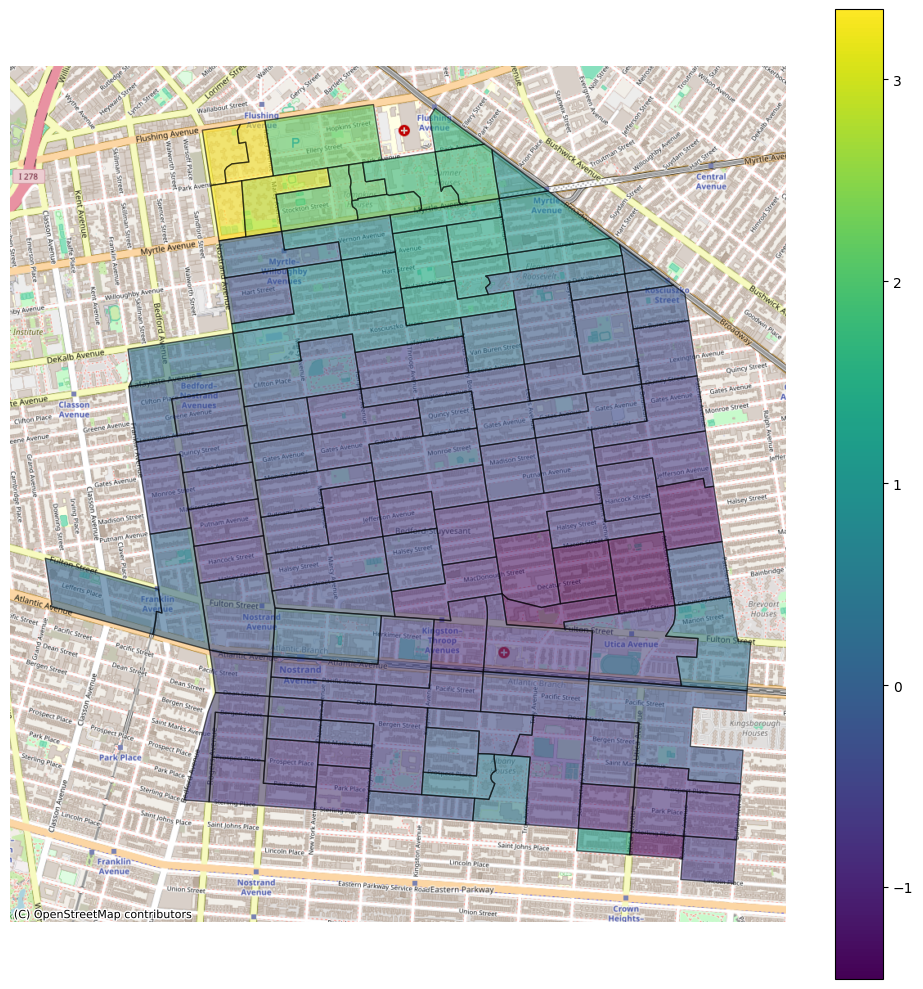

In [74]:
ax = fa_map_3857.plot(
    column='Factor1',
    legend=True,
    figsize=(10, 10),
    alpha=0.6,
    edgecolor='k'
)

ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik, 
    crs=fa_map_3857.crs
)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [102]:
label_map = {
    'vote_share': 'Osse Vote',
    'white_transplant_ratio': 'White Transplant Ratio',
    'nhb21p': 'Black %',
    'nhw21p': 'White %',
    'mhhi21': 'Median HH Income',
    'cvap21bapp': 'BA+',
    'w2admp': 'Journalists/Designers',
    'w2bgp': 'Janitors/Building',
    'w2hsp': 'Home Health Aid',
    'w2cmp': 'Software/Computers',
    'w2govp': 'Government'
}

In [100]:
cor_cols = ['vote_share','white_transplant_ratio','nhb21p','nhw21p','w2govp','cvap21bapp','w2admp','w2bgp','w2cmp','w2hsp','w2docp'] 
corr_df = co.merge(occ_df, left_on='ed_name', right_on='ElectDist', how='left')
corr_df['dpp20bs'] = corr_df['dpp20bs'] / 10
corr_matrix = corr_df[cor_cols].corr()
corr_matrix.rename(index=label_map, columns=label_map, inplace=True)

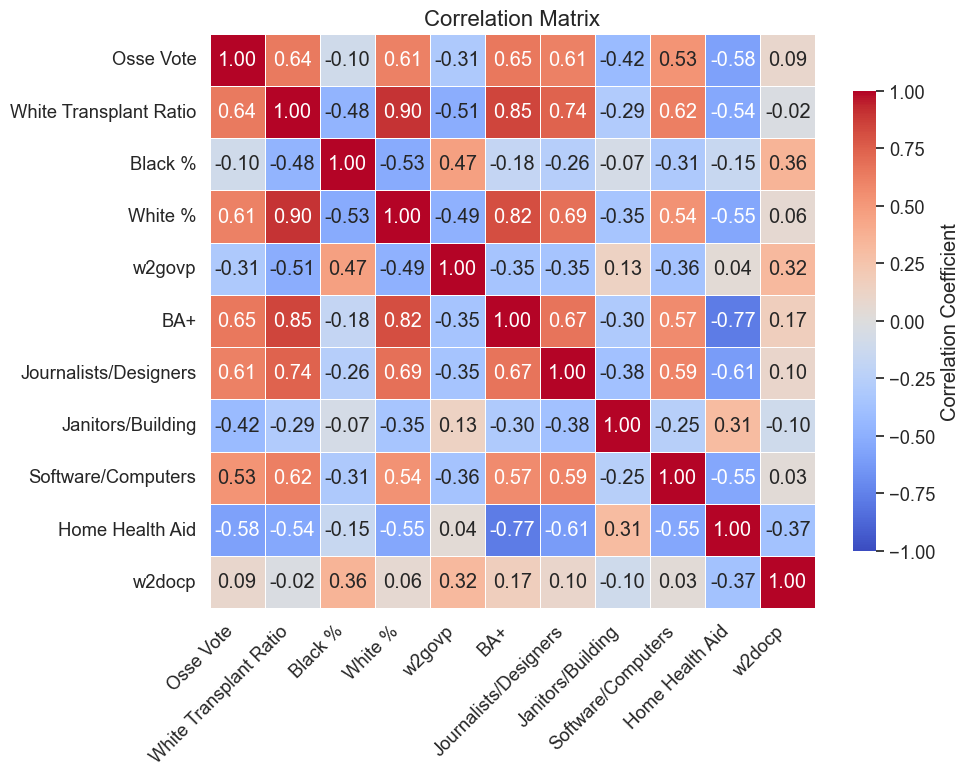

In [101]:
plt.figure(figsize=(10, 8))
sns.set(style="white", font_scale=1.2)

heatmap = sns.heatmap(
    corr_matrix,
    annot=True,             # Show correlation values
    fmt=".2f",              # 2 decimal places
    cmap="coolwarm",        # Diverging color palette
    vmin=-1, vmax=1,        # Fixed scale for comparability
    linewidths=0.5,         # Add lines between squares
    cbar_kws={"shrink": 0.8, 'label': 'Correlation Coefficient'}
)

plt.title("Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [152]:
thirty_six = ['Chi Osse','Henry L Butler','Tahirah A Moore']
fwe_thirty_six = fwe[fwe['matched_name'].isin(thirty_six)]

In [183]:
district_zips = ['11221','11233','11206','11213','11216']

In [184]:
by_zip_36 = fwe_thirty_six.groupby(['matched_name','ZIP'])['AMNT'].sum().reset_index()
by_zip_36['ZIP'] = by_zip_36['ZIP'].astype(str)
compare = by_zip_36.pivot(index='ZIP',columns='matched_name',values='AMNT').fillna(0).reset_index()

In [185]:
compare_nyc = compare[compare['ZIP'].isin(zip_list)]
compare_district = compare[compare['ZIP'].isin(district_zips)]

In [201]:
compare_nyc['c_t_dif'] = compare_nyc['Chi Osse'] - compare_nyc['Tahirah A Moore']
compare_district['c_t_dif'] = compare_district['Chi Osse'] - compare_district['Tahirah A Moore']
compare_nyc['c_h_dif'] = compare_nyc['Chi Osse'] - compare_nyc['Henry L Butler']
compare_district['c_h_dif'] = compare_district['Chi Osse'] - compare_district['Henry L Butler']
compare_nyc['top_candidate'] = compare_nyc[['Chi Osse', 'Henry L Butler', 'Tahirah A Moore']].idxmax(axis=1)
compare_district['top_candidate'] = compare_district[['Chi Osse', 'Henry L Butler', 'Tahirah A Moore']].idxmax(axis=1)

C:\Users\samtg\AppData\Local\Temp\ipykernel_12036\361633893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_nyc['c_t_dif'] = compare_nyc['Chi Osse'] - compare_nyc['Tahirah A Moore']
C:\Users\samtg\AppData\Local\Temp\ipykernel_12036\361633893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_district['c_t_dif'] = compare_district['Chi Osse'] - compare_district['Tahirah A Moore']
C:\Users\samtg\AppData\Local\Temp\ipykernel_12036\361633893.py:3: SettingWithCopyWarning: 
A value is trying 

In [202]:
zip_map = compare_nyc.merge(nyc_zip, left_on='ZIP', right_on='zcta', how='left')
zip_map = gpd.GeoDataFrame(zip_map)
brooklyn_map = zip_map[zip_map['ZIP'].isin(brooklyn_zips)]

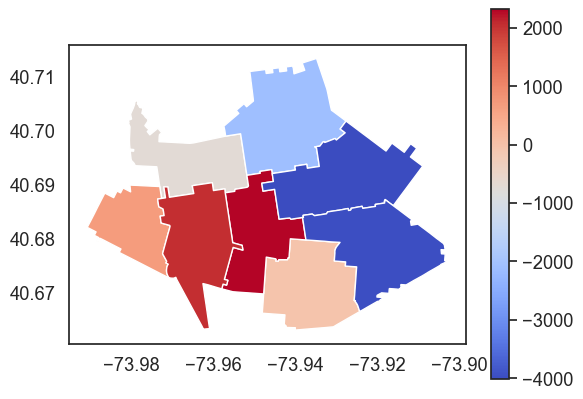

In [173]:
brooklyn_map.plot(column='c_h_dif', cmap='coolwarm', legend=True)
plt.show()

In [203]:
bm_3857 = brooklyn_map.to_crs(epsg=3857)

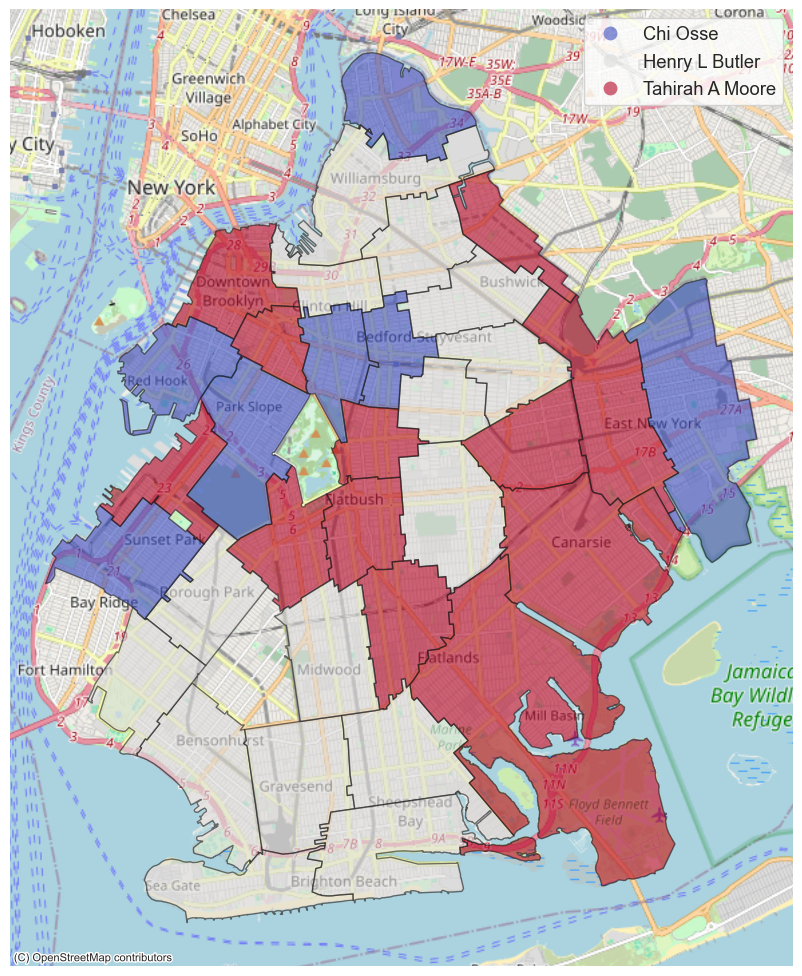

In [204]:
ax = bm_3857.plot(
    column='top_candidate',
    legend=True,
    figsize=(10, 10),
    alpha=0.6,
    edgecolor='k',
    cmap='coolwarm'
)

ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik, 
    crs=gdf_3857.crs
)

ax.set_axis_off()
plt.tight_layout()
plt.show()